# About

This notebook is a Proof of Concept of machine learning application to predict desert items in ComprasGov.

# Imports

In [10]:
# Installing Required Libraries
# pip install pandas numpy matplotlib seaborn sqlalchemy scikit-learn scipy xgboost lightgbm catboost tpot sweetviz torch sqlalchemy

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from tpot import TPOTClassifier

# Importing User Sensible Data
from sql.postgres_connection import (dbname, password, host, port, database)
from sql.comprasgov_poc_item_deserto_sql import (train_sql_query, test_sql_query)

# Data

## Database Connection

In [19]:
# Database Connection Function
def read_data_from_postgres(query):
    try:
        engine = create_engine(f'postgresql://{dbname}:{password}@{host}:{port}/{database}')
        df = pd.read_sql_query(query, engine)
        
    except Exception as e:
        print("An error occurred:", e)
        
    return df

# Test Connection
df = read_data_from_postgres()
df_copy = df.copy()
df

TypeError: read_data_from_postgres() missing 1 required positional argument: 'query'

## Data Exploration and Feature Engineering

In [12]:
# Describe columns types
df.dtypes

numero_item                                int64
valor_estimado                           float64
quantidade_solicitada                      int64
variacao_minima_entre_lances             float64
data_hora_prevista_abertura_sp    datetime64[ns]
situacao_compra                           object
it_sg_uf                                  object
id                                        object
it_sg_regiao                              object
codigo_item_catalogo                      object
it_in_tipo_administracao                  object
codigo_grupo_secao                        object
codigo_classe_divisao                     object
codigo_pdm_grupo                          object
numero_uasg                               object
it_co_orgao                               object
it_co_orgao_vinculado                     object
it_co_orgao_superior                      object
in_orcamento_sigiloso                       bool
in_deserto                                  bool
in_agrupado         

In [13]:
df = df_copy.copy()

# Drop unuseful attributes
columns_to_ignore = ['data_hora_prevista_abertura_sp', 'situacao_compra', 'id', 'it_sg_regiao', 'in_pregao', 
                    'descricao', 'it_no_orgao', 'it_no_orgao_vinculado', 'it_no_orgao_superior', 
                    'nome_grupo_secao', 'nome_classe_divisao', 'nome_pdm_grupo']

df = df.drop(columns_to_ignore, axis=1, inplace=False)

# Identify boolean columns in the DataFrame
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

# Identify categorical columns in the DataFrame manually
# bool_cols = [
#     'in_orcamento_sigiloso',
#     'in_deserto',
#     'in_agrupado',
#     'in_aberto',
#     'in_srp',
#     'in_exclusivo_me_epp',
#     'in_federal',
#     'in_poder_executivo',
#     'in_percentual',
#     'in_servico',
#     # 'in_pregao'
#     ]

# Convert boolean columns to integers
df[bool_cols] = df[bool_cols].astype(int)

# Identify categorical columns in the DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert categorical columns to integers manually
# categorical_cols = [
#     # 'situacao_compra',
#     'it_sg_uf',
#     # 'id',
#     # 'it_sg_regiao',
#     'codigo_item_catalogo',
#     'it_in_tipo_administracao',
#     'codigo_grupo_secao',
#     'codigo_classe_divisao',
#     'codigo_pdm_grupo',
#     'numero_uasg',
#     'it_co_orgao',
#     'it_co_orgao_vinculado',
#     'it_co_orgao_superior'
# ]

df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

df.dtypes

numero_item                       int64
valor_estimado                  float64
quantidade_solicitada             int64
variacao_minima_entre_lances    float64
it_sg_uf                          int32
codigo_item_catalogo              int32
it_in_tipo_administracao          int32
codigo_grupo_secao                int32
codigo_classe_divisao             int32
codigo_pdm_grupo                  int32
numero_uasg                       int32
it_co_orgao                       int32
it_co_orgao_vinculado             int32
it_co_orgao_superior              int32
in_orcamento_sigiloso             int32
in_deserto                        int32
in_agrupado                       int32
in_aberto                         int32
in_srp                            int32
in_exclusivo_me_epp               int32
in_federal                        int32
in_poder_executivo                int32
in_percentual                     int32
in_servico                        int32
dtype: object

## SweetViz

In [14]:
# SweetViz Setup
target_feature ='in_deserto'
feature_config = sv.FeatureConfig(skip=None) # Possible parameters: skip, force_cat, force_num and force_text

### Manual Run

                                             |          | [  0%]   00:00 -> (? left)


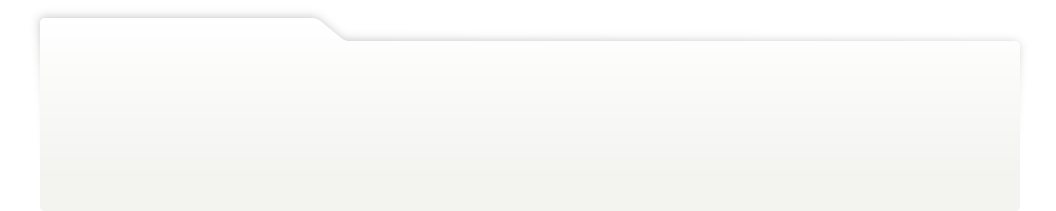
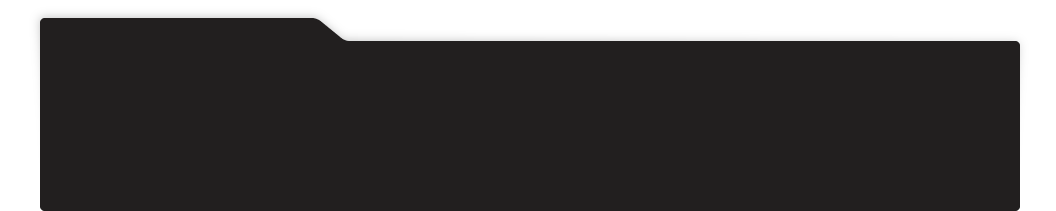
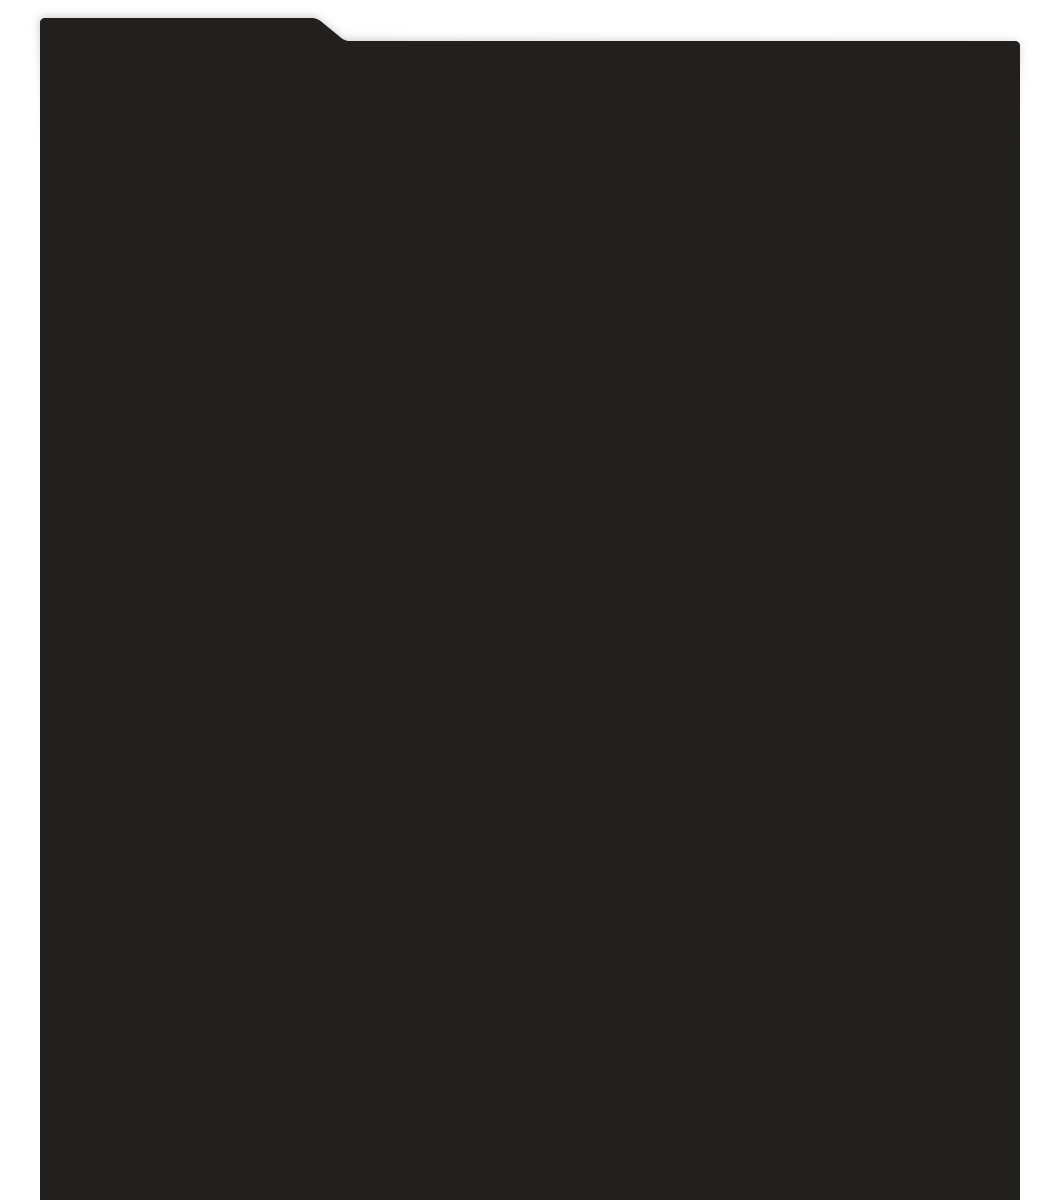
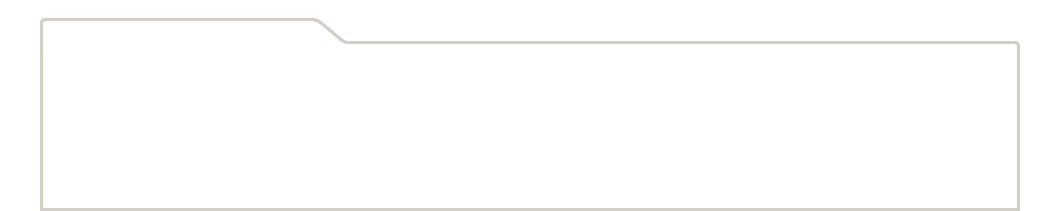
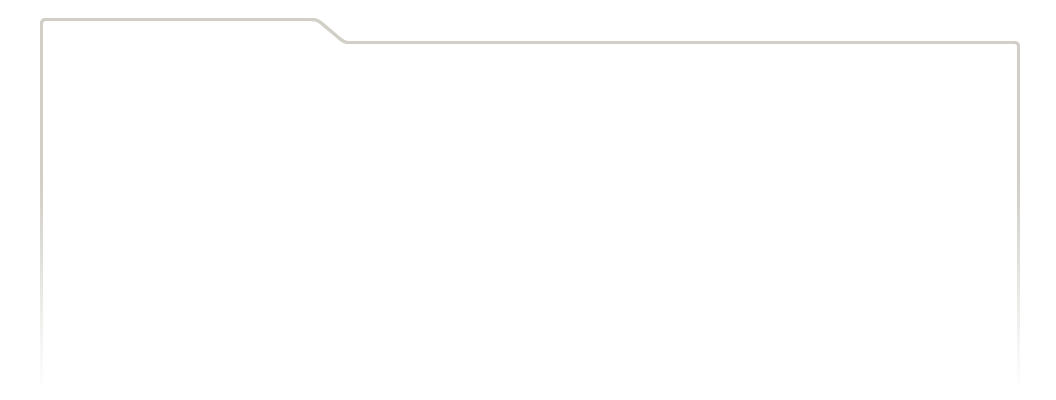
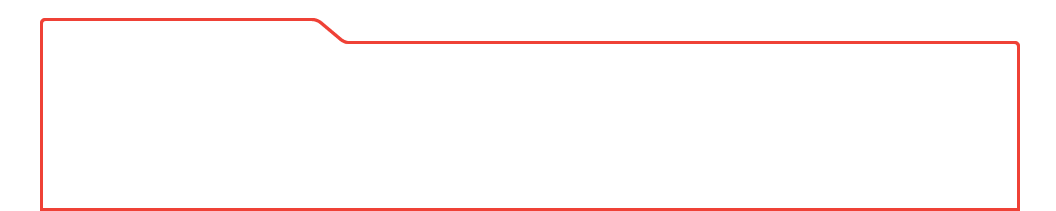
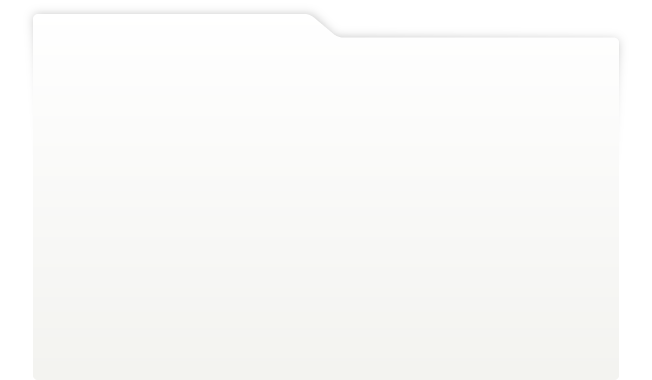
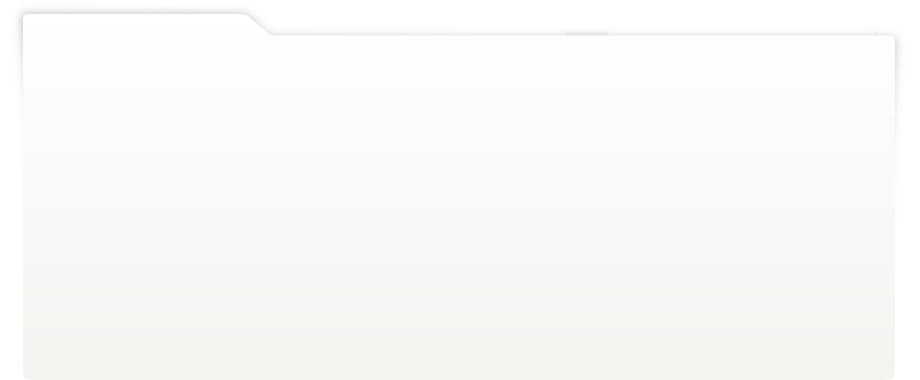
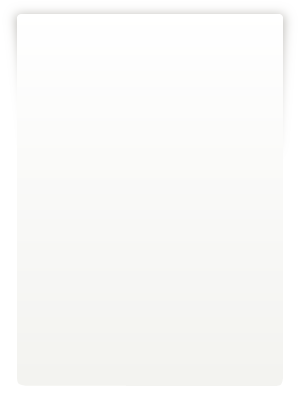
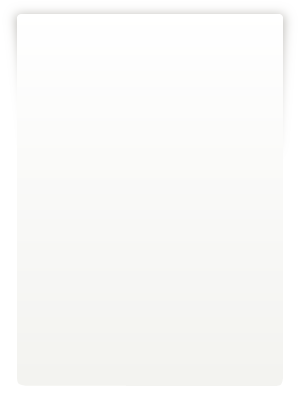
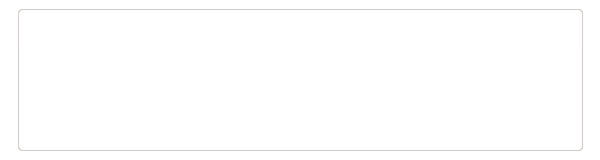
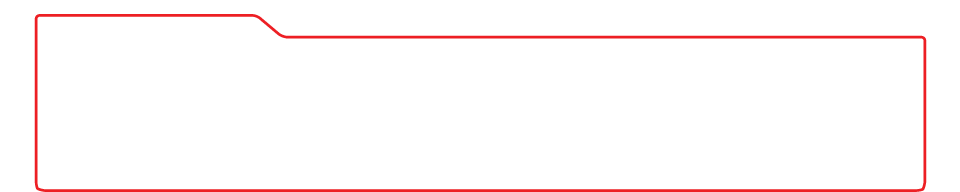
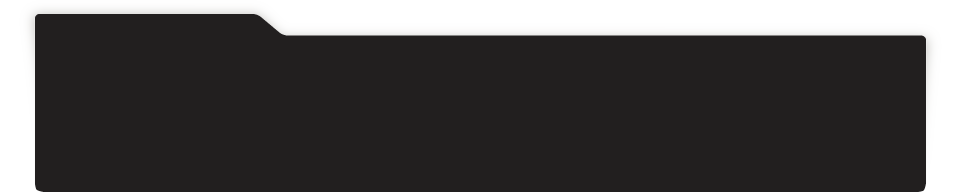
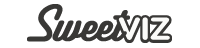
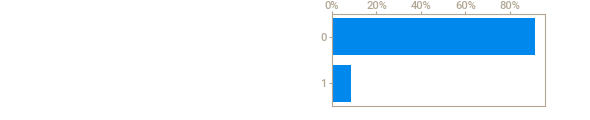
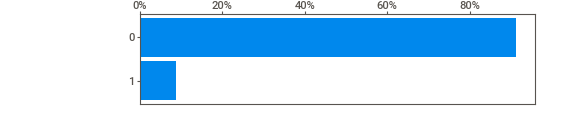
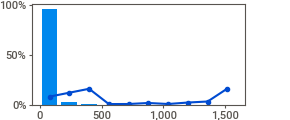
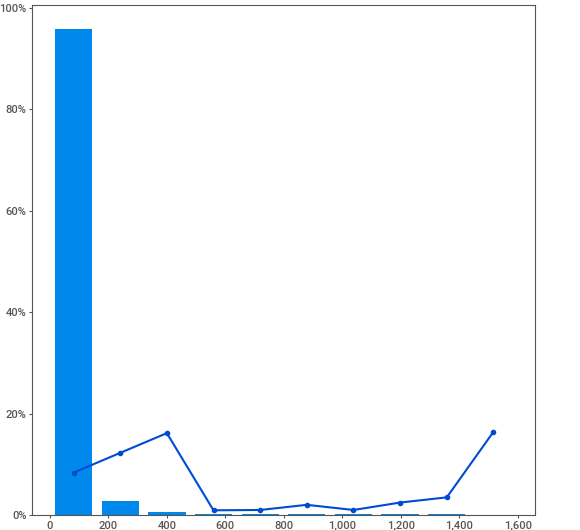
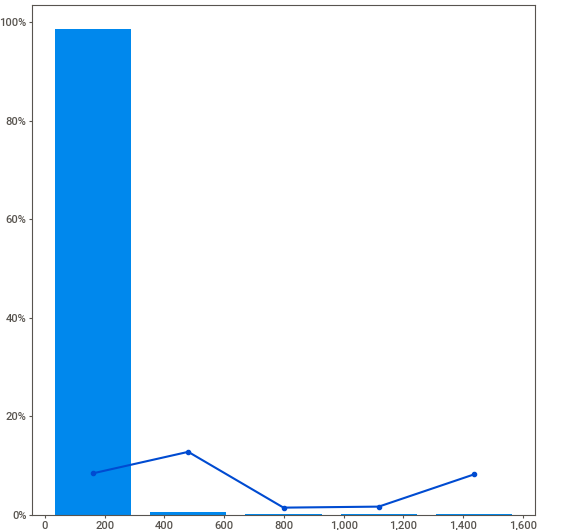
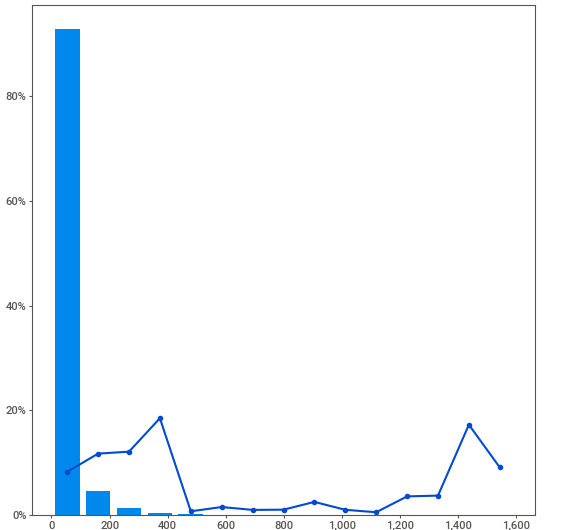
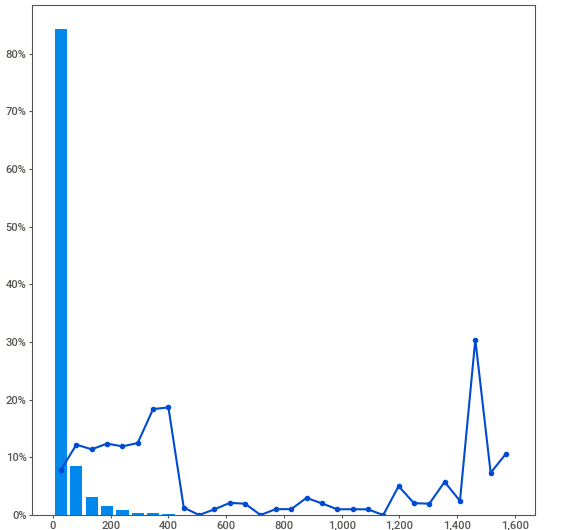
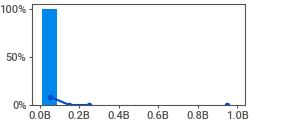
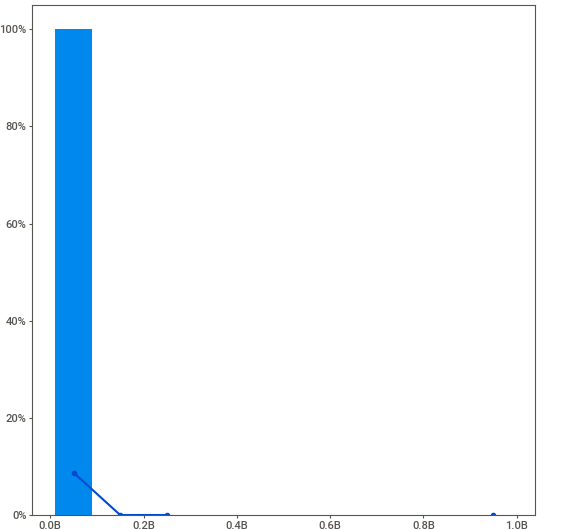
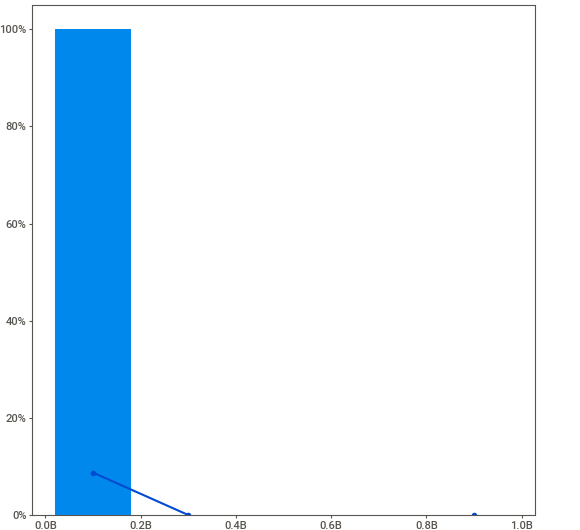
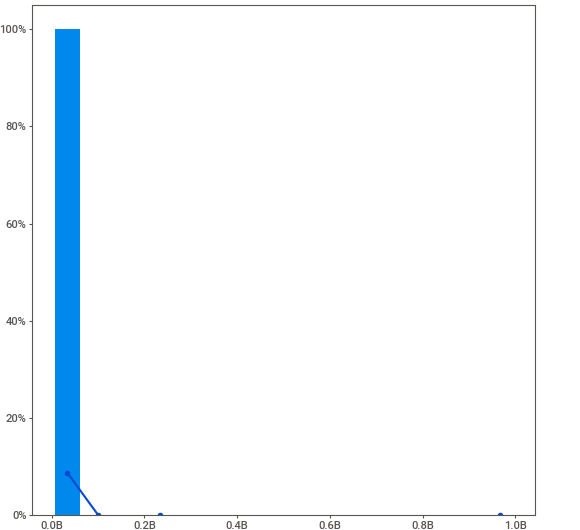
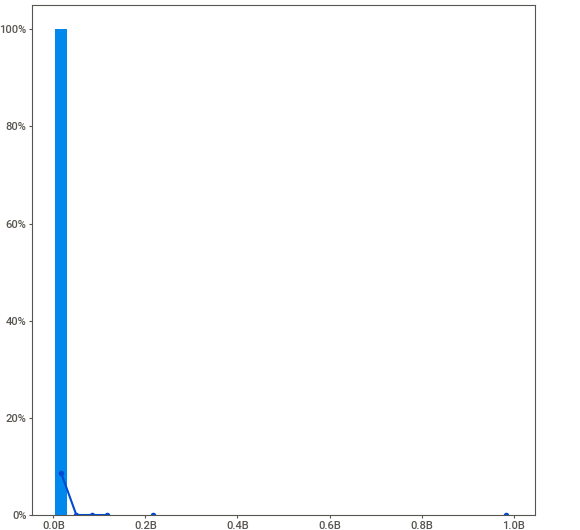
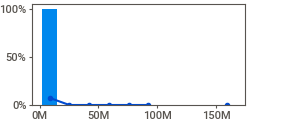
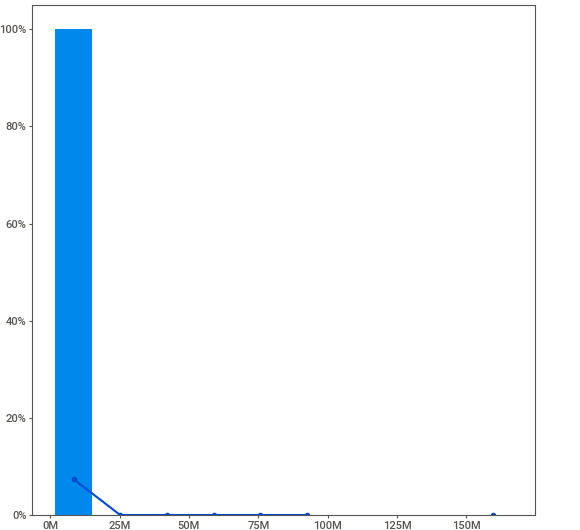
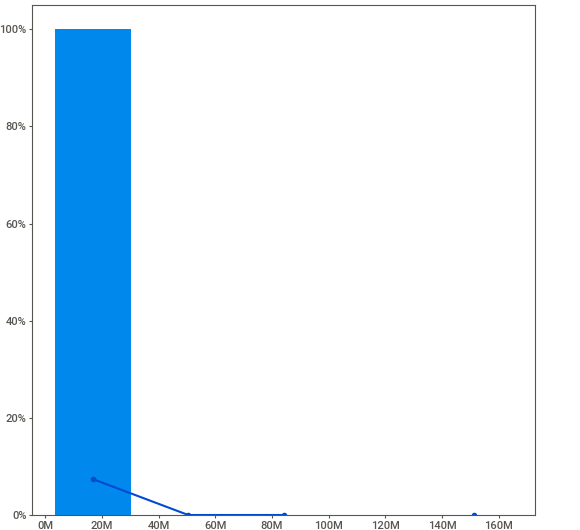
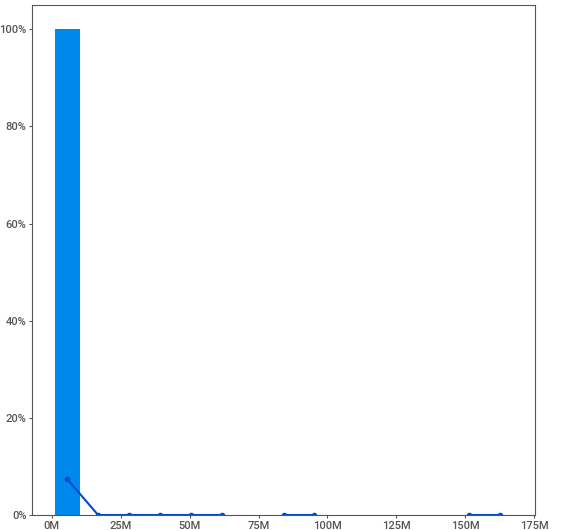
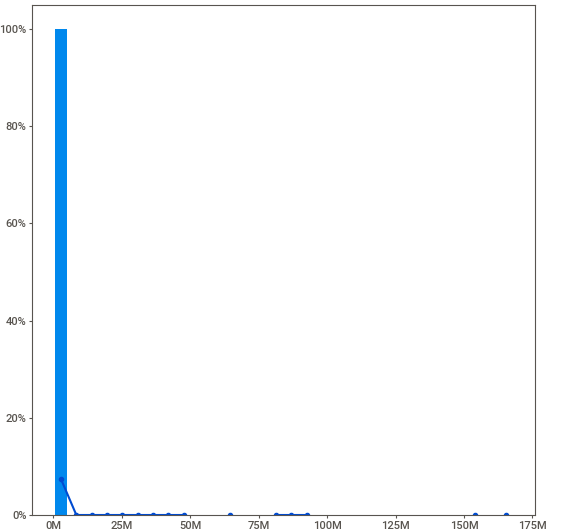
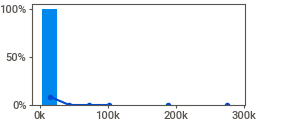
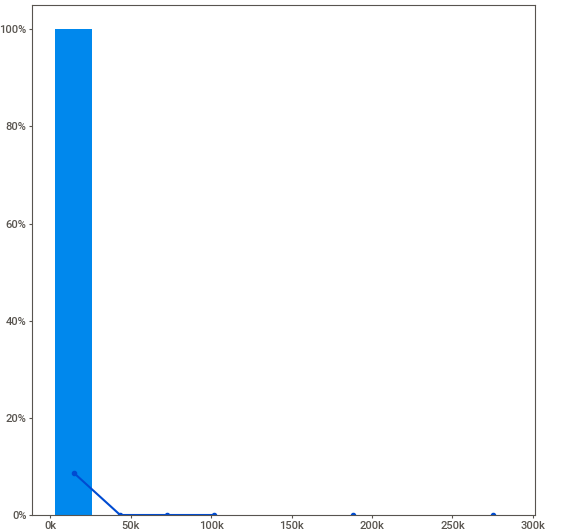
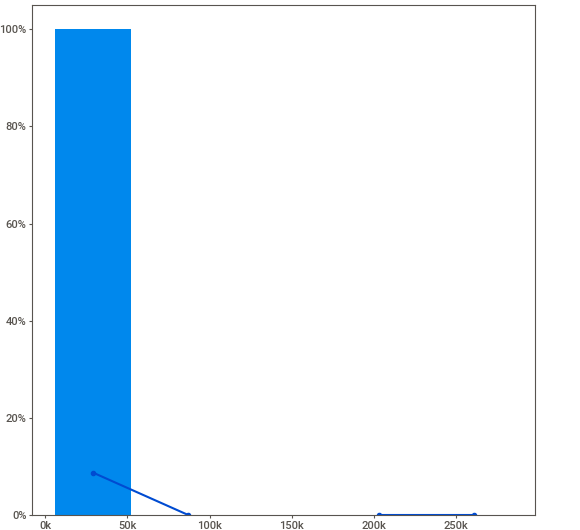
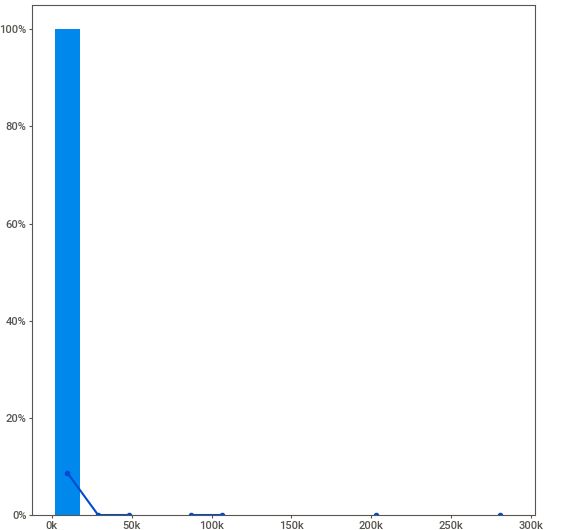
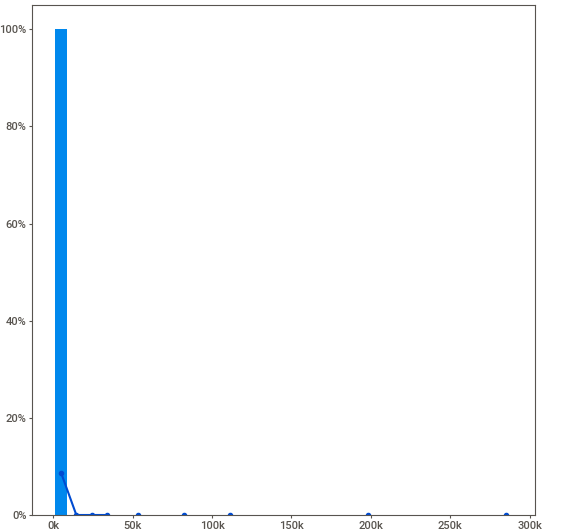
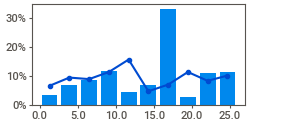
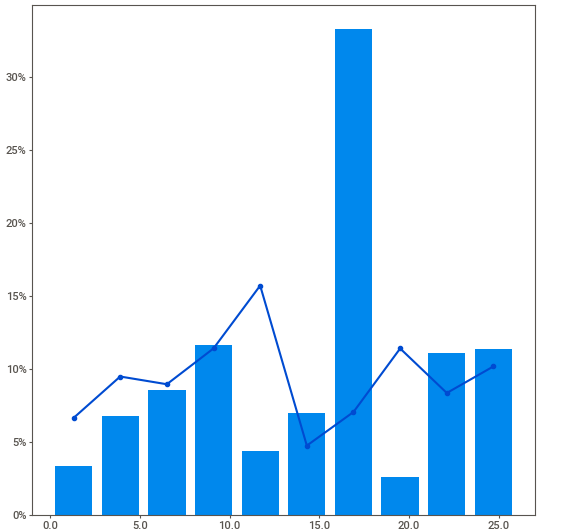
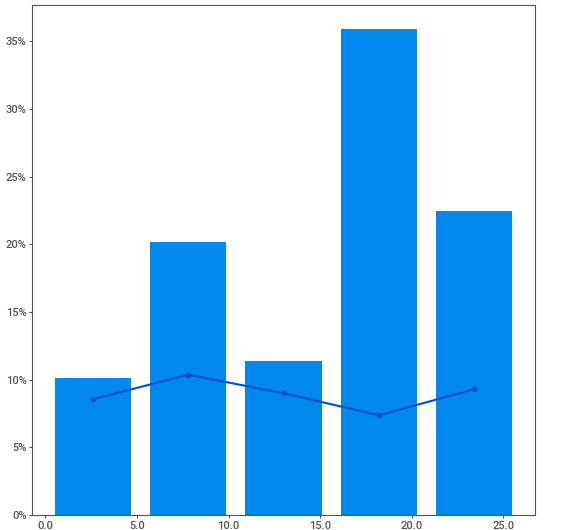
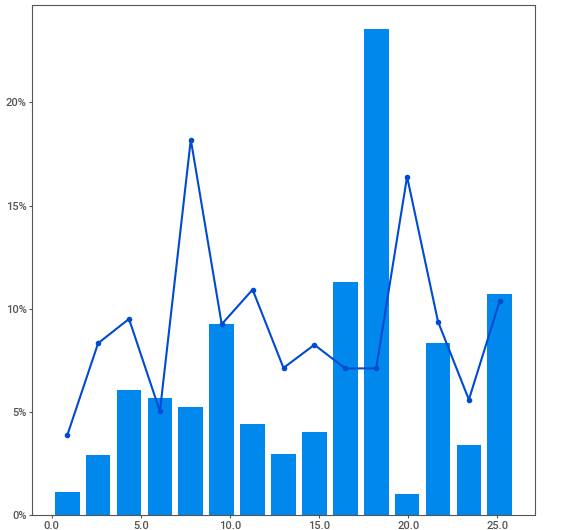
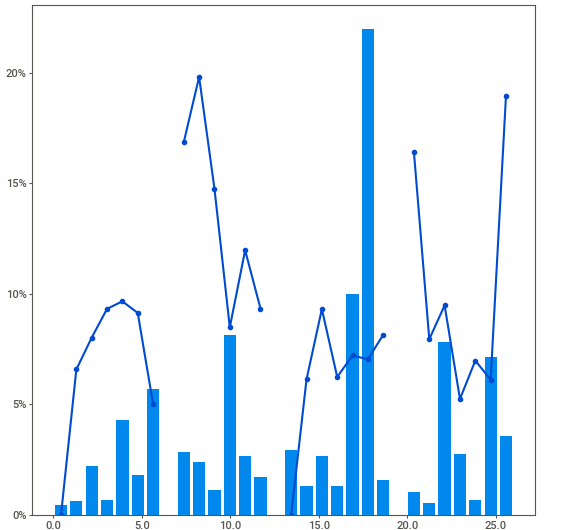
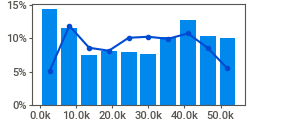
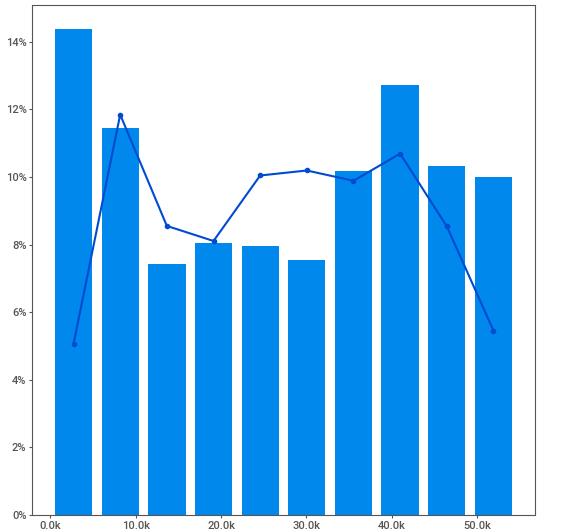
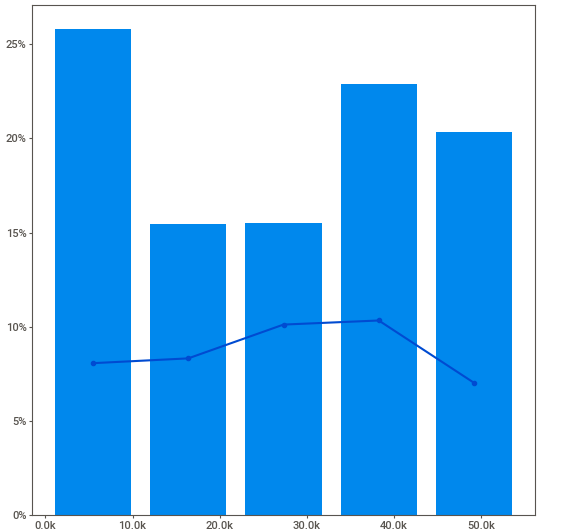
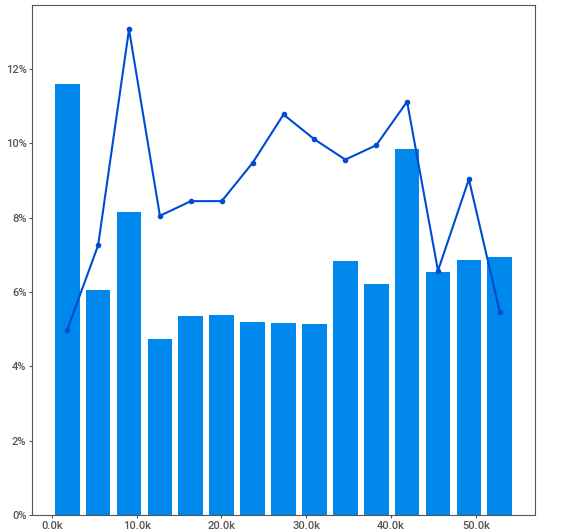
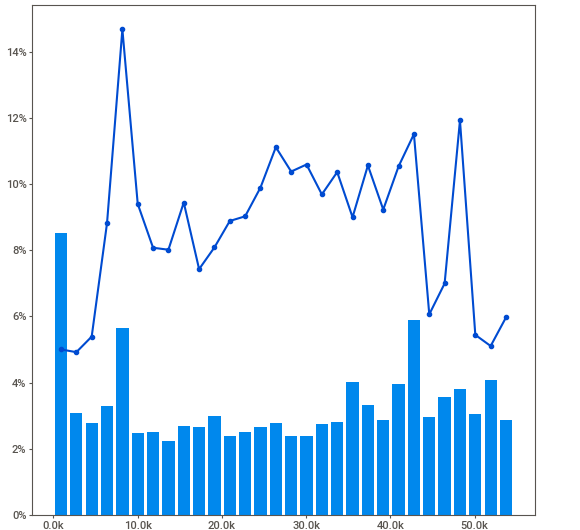
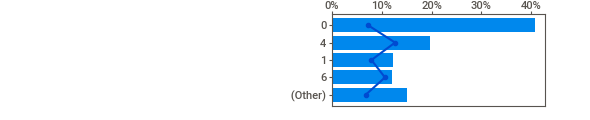
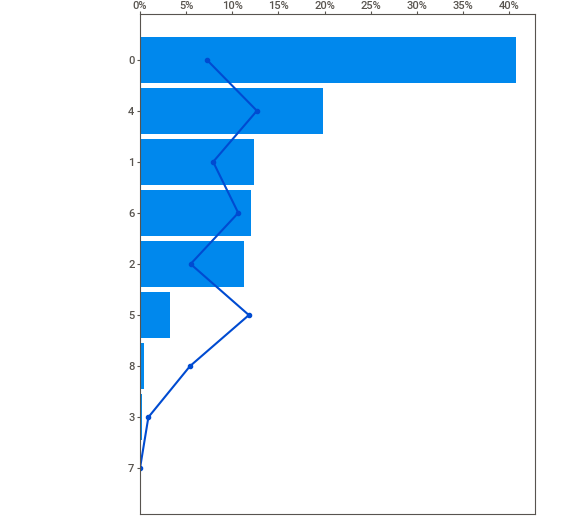
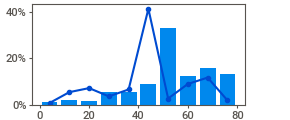
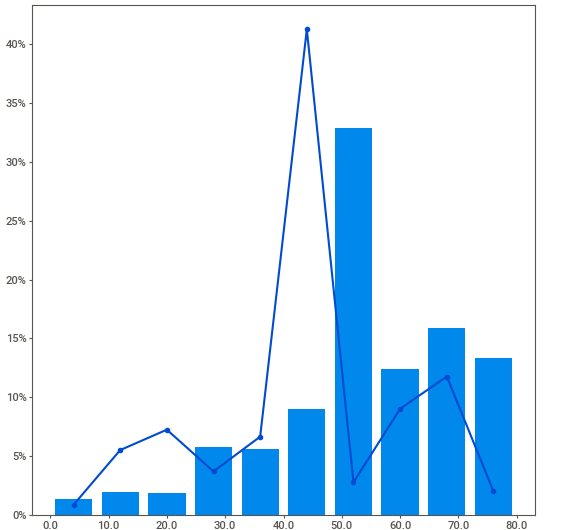
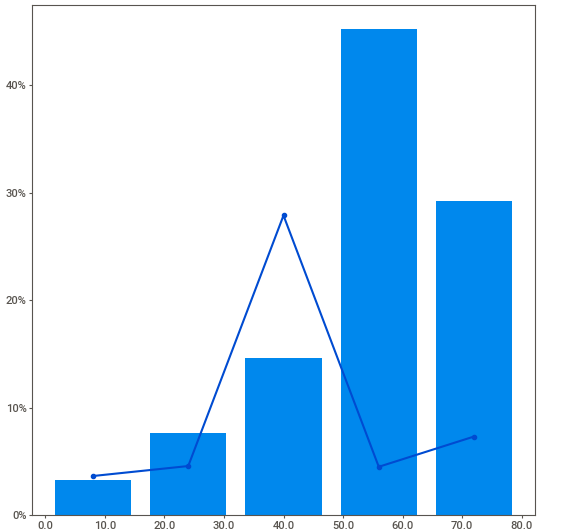
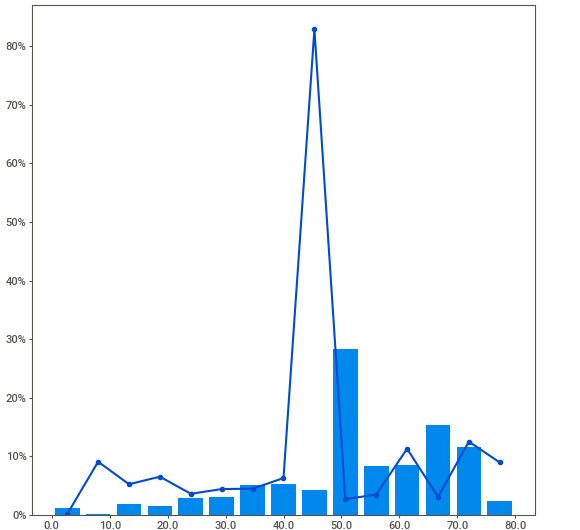
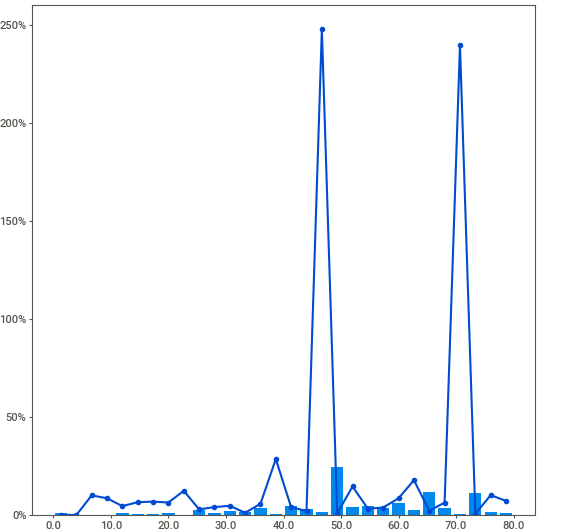
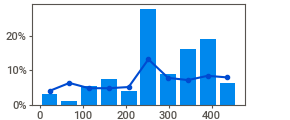
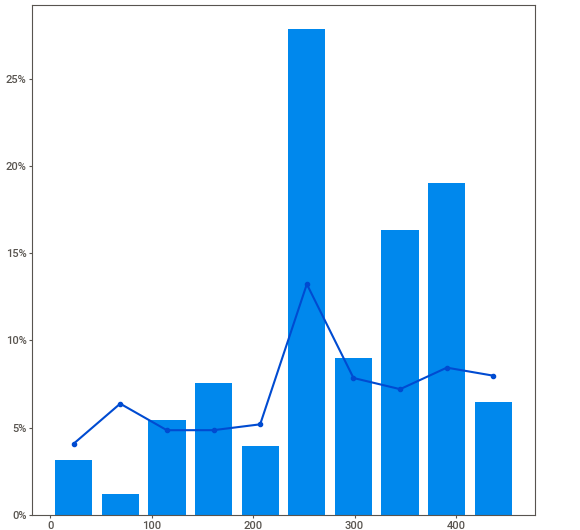
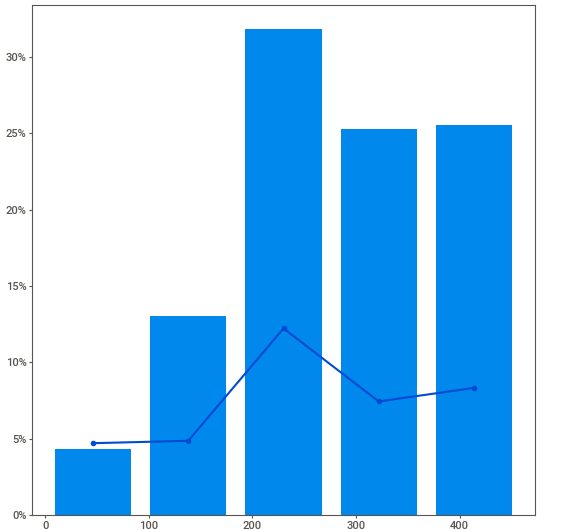
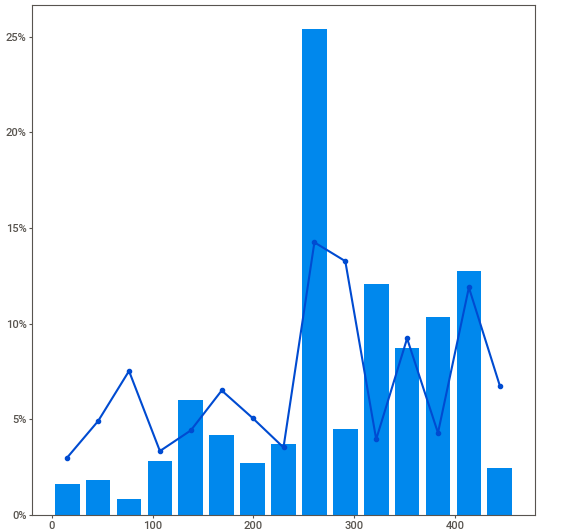
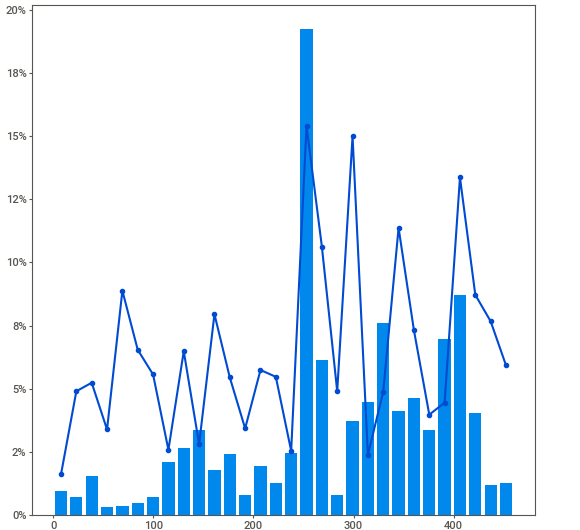
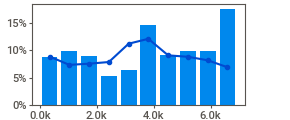
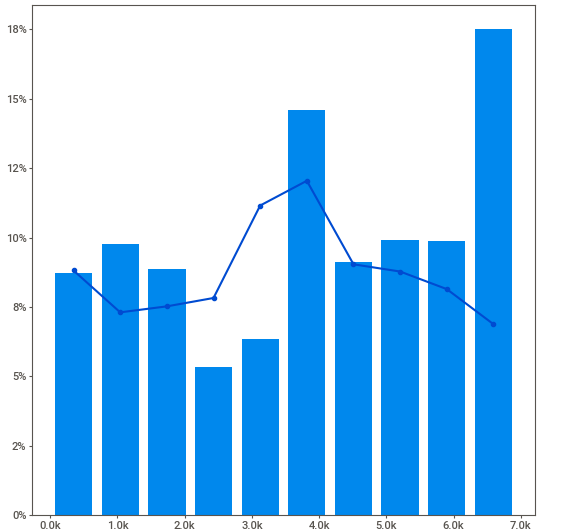
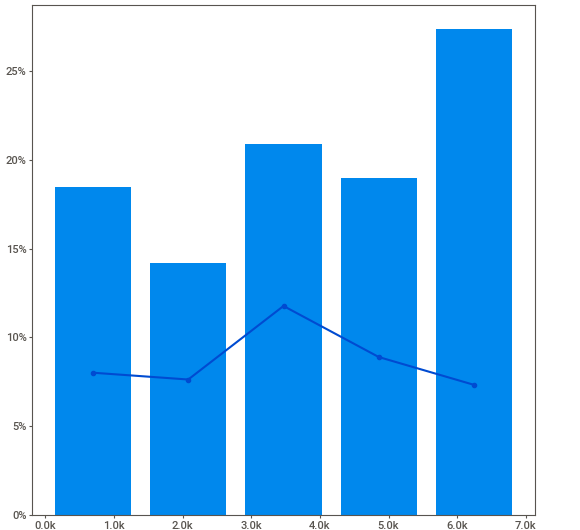
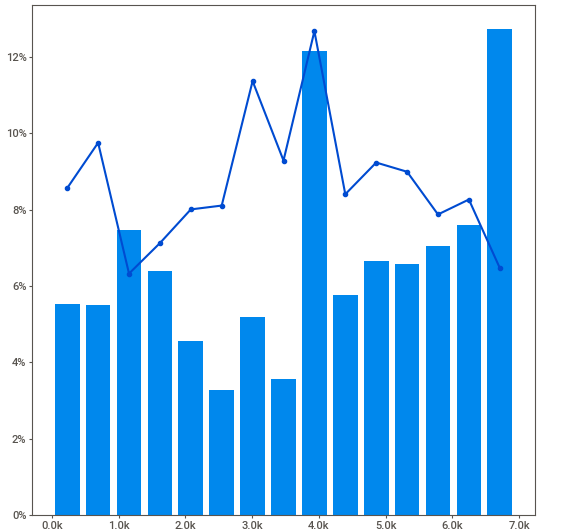
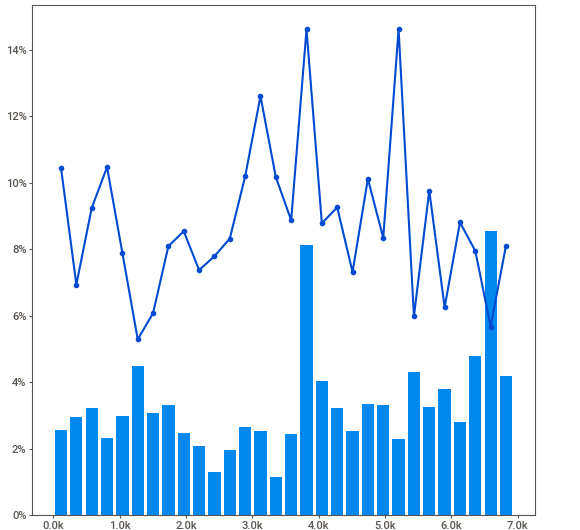
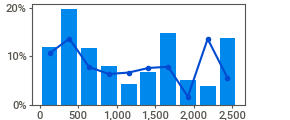
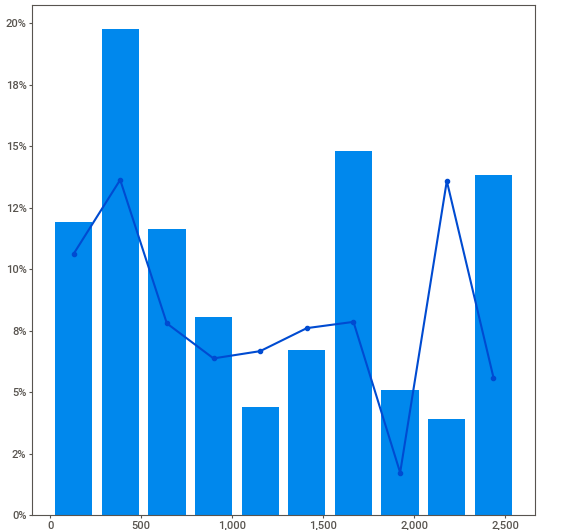
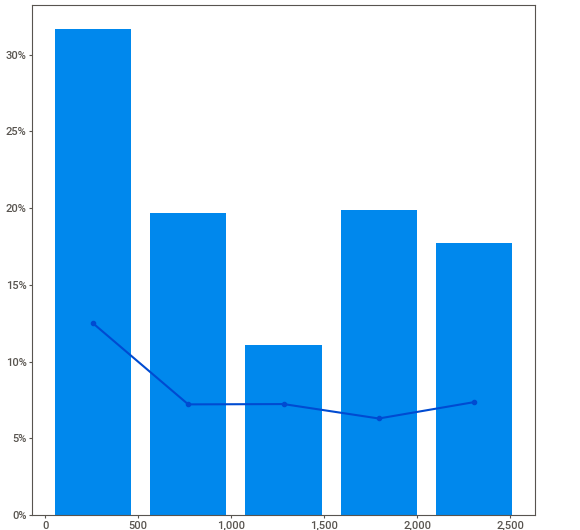
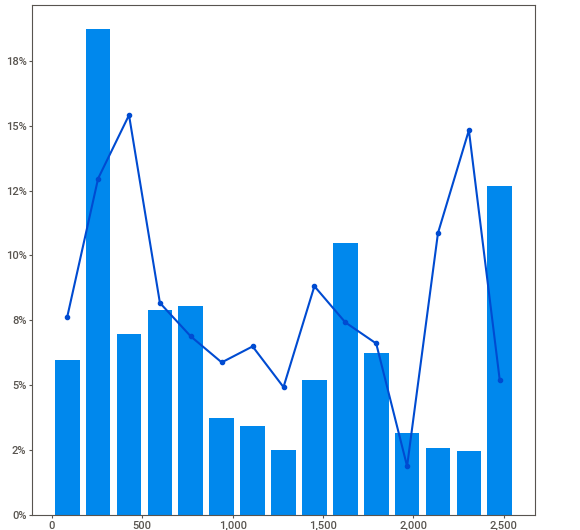
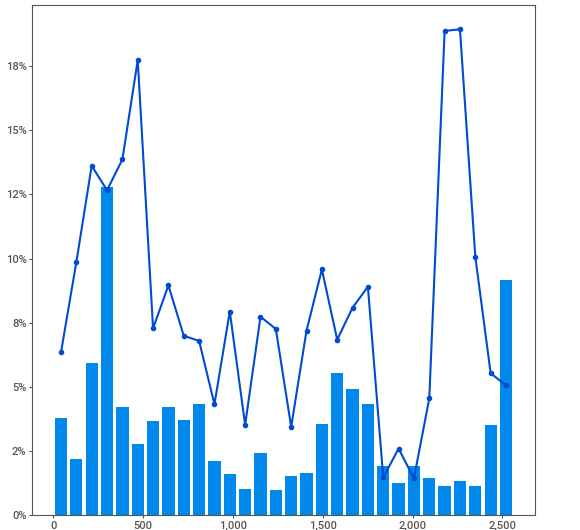
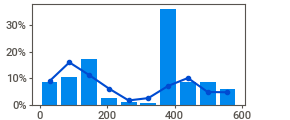
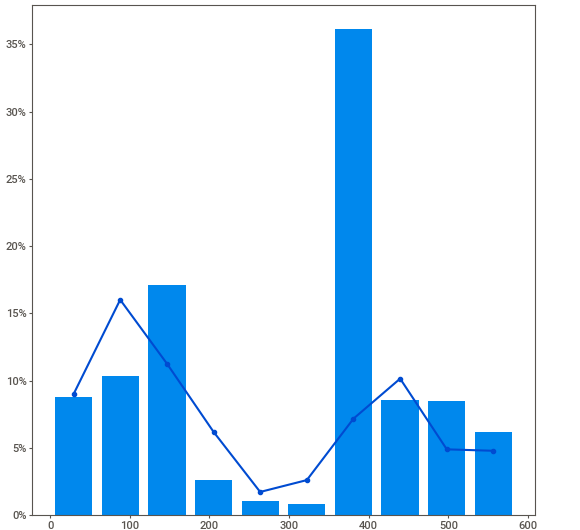
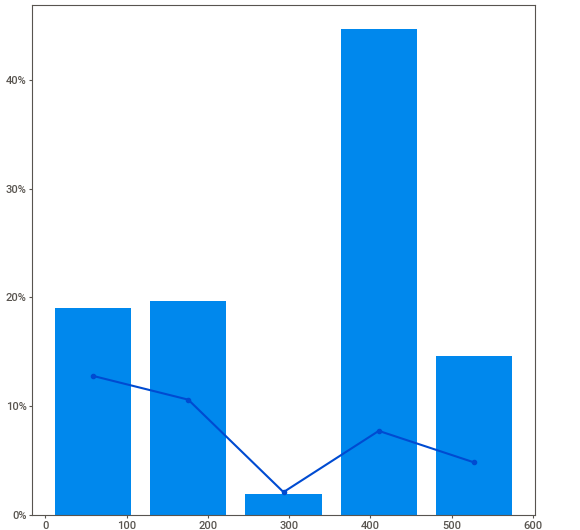
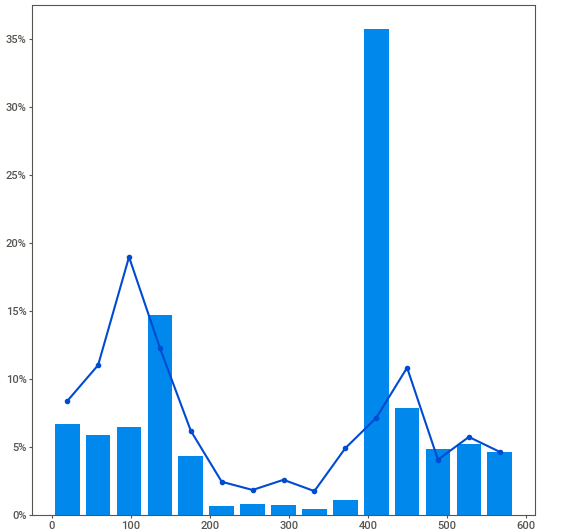
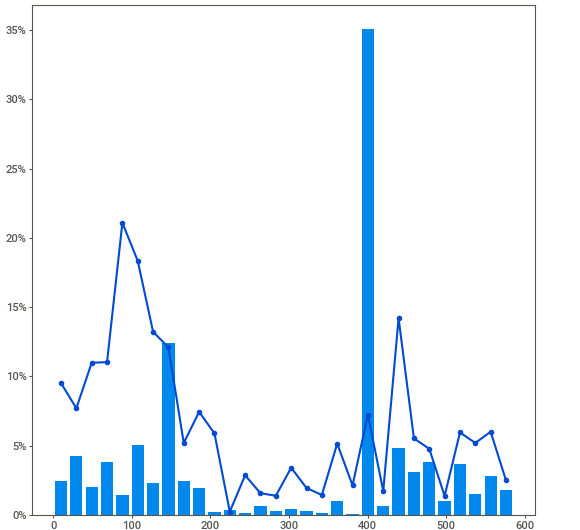
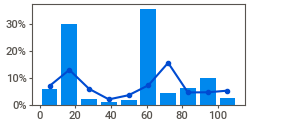
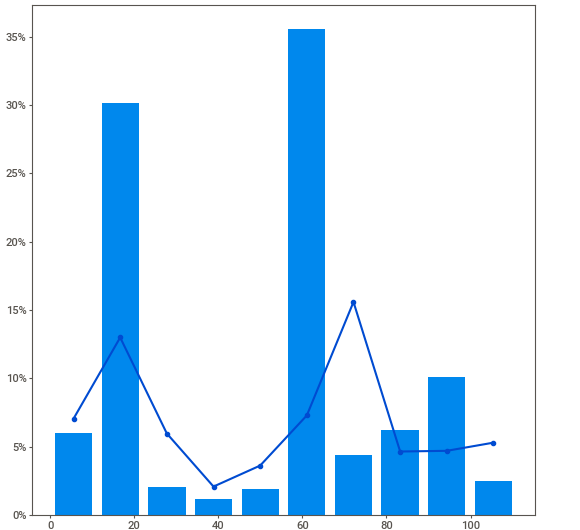
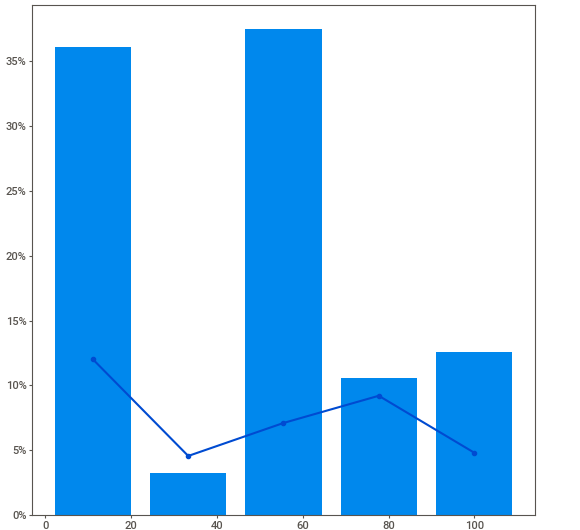
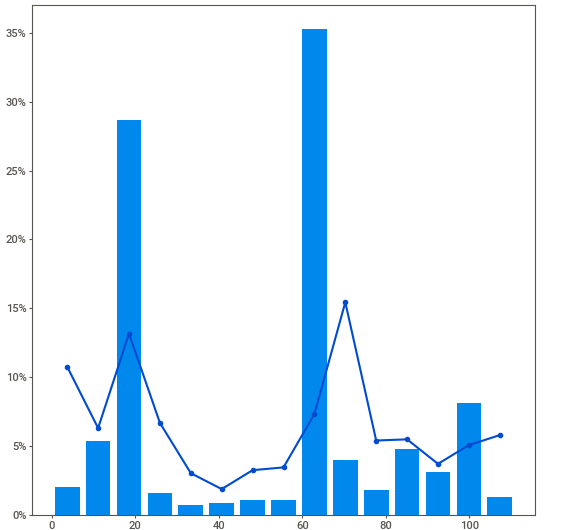
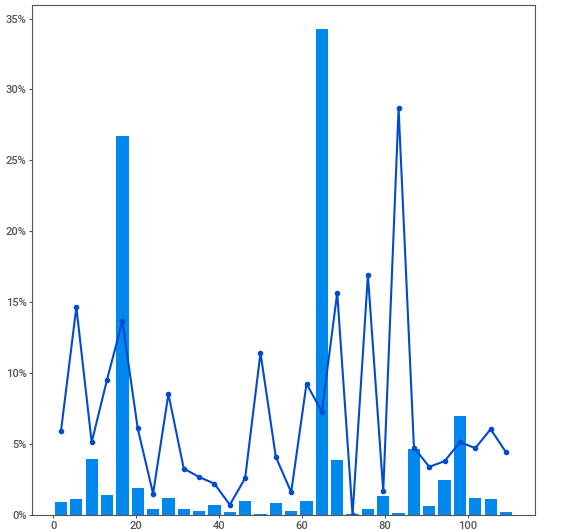
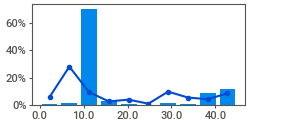
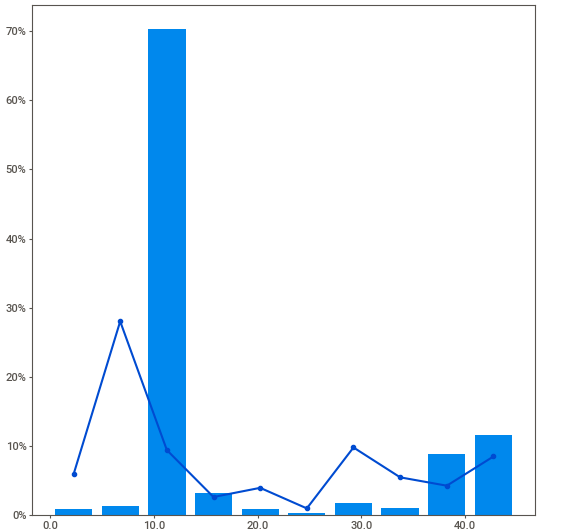
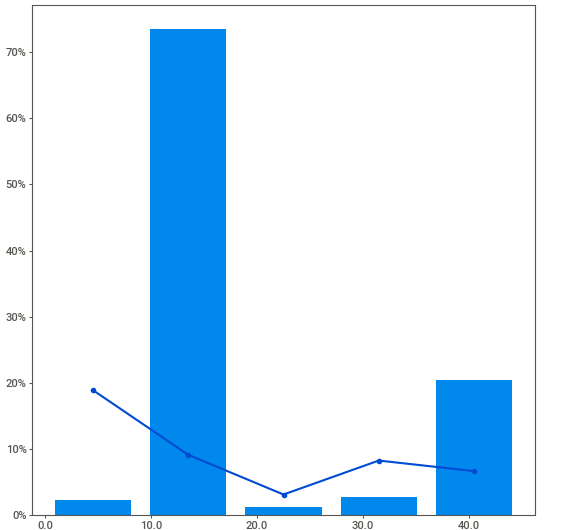
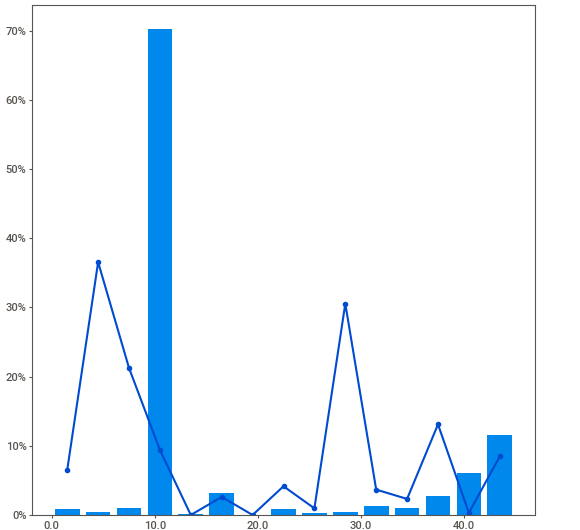
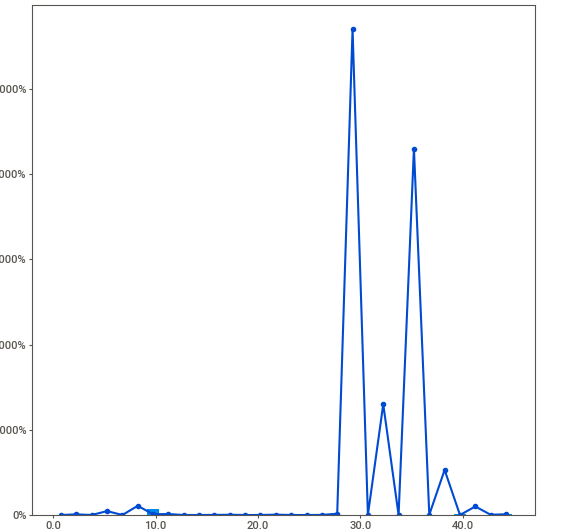
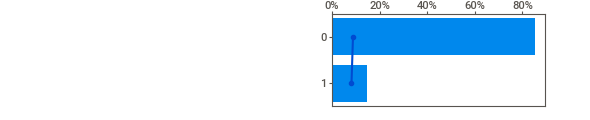
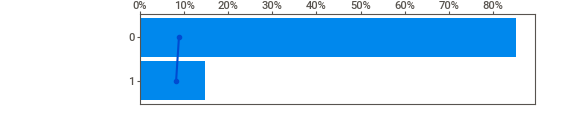
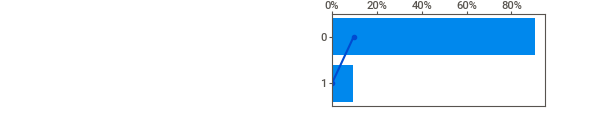
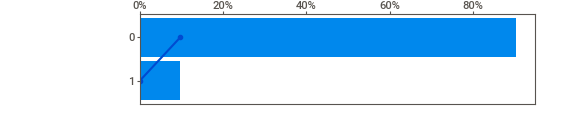
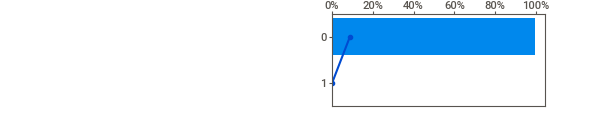
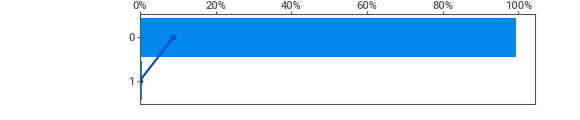
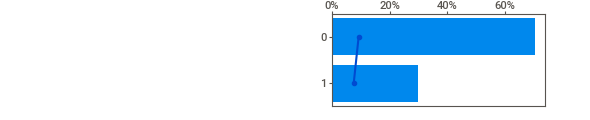
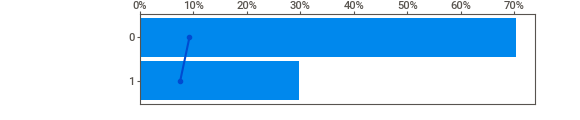
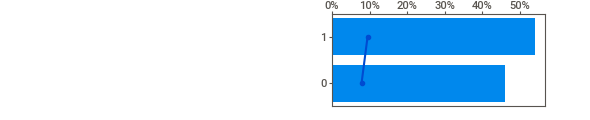
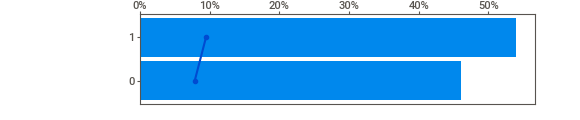
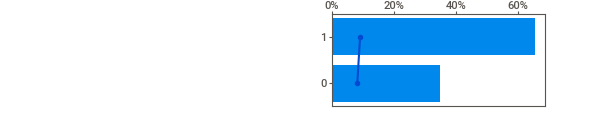
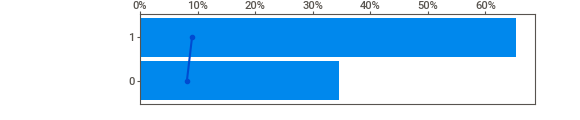
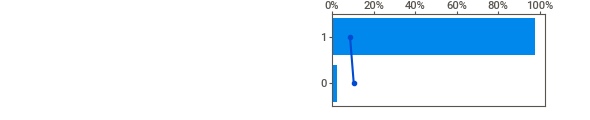
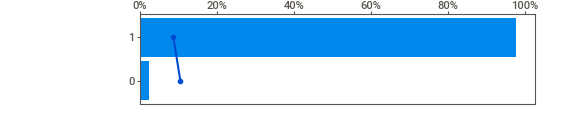
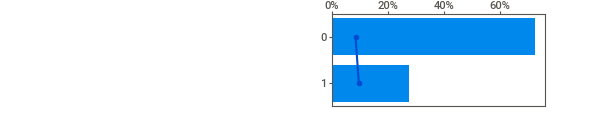
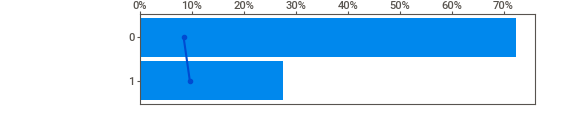
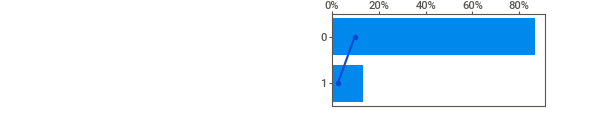
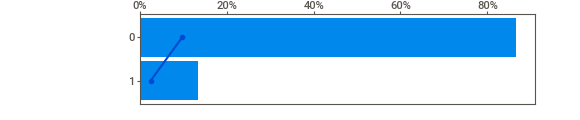
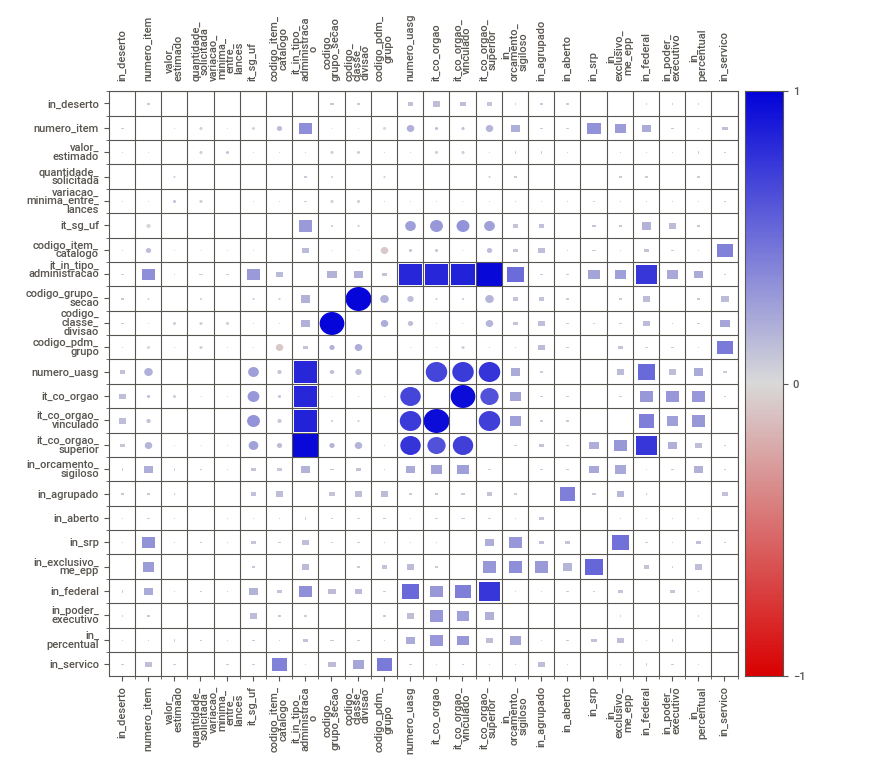
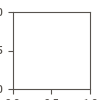

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
# Manual Run
my_report = sv.analyze(df, target_feat=target_feature, feat_cfg=feature_config)
my_report.show_notebook(w="100%",
                        h=None, 
                        scale=None, 
                        layout='vertical',
                        filepath=None)
my_report.show_html(filepath='sweetviz_report.html', 
                    open_browser=True, 
                    layout='vertical', 
                    scale=None)

## Transformations and Feature Engineering

In [15]:
def data_etl(df):

    columns_to_ignore = ['data_hora_prevista_abertura_sp', 'situacao_compra', 'id', 'it_sg_regiao', 'in_pregao', 
                        'descricao', 'it_no_orgao', 'it_no_orgao_vinculado', 'it_no_orgao_superior', 
                        'nome_grupo_secao', 'nome_classe_divisao', 'nome_pdm_grupo']

    df = df.drop(columns_to_ignore, axis=1, inplace=False)

    # Identify boolean columns in the DataFrame
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers
    df[bool_cols] = df[bool_cols].astype(int)

    # Identify categorical columns in the DataFrame
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

    return df

## Outliers Analysis

In [16]:
def remove_outliers(df):
    return df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

# Modeling

## AutoML Function

In [9]:
# AutoML for Model Selection and Ranking
def run_automl(X_train, y_train):
    tpot = TPOTClassifier(generations=5, 
                          population_size=20, 
                          verbosity=2)
    tpot.fit(X_train, y_train)
    return tpot

# Apply AutoML Learning Models
def train_test_evaluate_automl(X, y, X_val, y_val):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Run AutoML
    automl_model = run_automl(X_train, y_train)
    
    models = {"AutoML": automl_model}
    
    metrics = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Validate with external CSV
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        metrics[name] = {
            'Test Accuracy': accuracy,
            'Validation Accuracy': val_accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        }
        
        print(f"{name} Model Metrics:")
        print(f"Test Accuracy: {accuracy}")
        print(f"Validation Accuracy: {val_accuracy}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
    return metrics

## Models and Metrics

In [17]:
# Train, Test, and Evaluate Machine Learning Models
def train_test_evaluate_models(X, y, X_val, y_val):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Run AutoML
    automl_model = run_automl(X_train, y_train)
    
    models = {
        "AutoML": automl_model,
        "RandomForest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(),
        "LightGBM": LGBMClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0)
    }
    
    metrics = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Validate with external CSV
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        metrics[name] = {
            'Test Accuracy': accuracy,
            'Validation Accuracy': val_accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        }
        
        print(f"{name} Model Metrics:")
        print(f"Test Accuracy: {accuracy}")
        print(f"Validation Accuracy: {val_accuracy}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
    return metrics

# Main

In [20]:
if __name__ == "__main__":
    # Reading Data from PostgreSQL
    df = read_data_from_postgres(train_sql_query)
    
    # ETL Operations
    df = data_etl(df)
    
    # Remove Outliers
    df = remove_outliers(df)
    
    # Prepare Data for Models
    X = df.drop('in_deserto', axis=1)  # 'in_deserto' is the target attribute
    y = df['in_deserto']
    
    # Read Validation Data from PostgreSQL
    df_val = read_data_from_postgres(test_sql_query)
    df_val = data_etl(df_val)

    X_val = df_val.drop('in_deserto', axis=1)
    y_val = df_val['in_deserto']
    
    # Train, Test, and Evaluate Models
    metrics = train_test_evaluate_models(X, y, X_val, y_val)
    
    # Comparative Metrics
    print("\nComparative Metrics:")
    for name, metric in metrics.items():
        print(f"{name} - Test Accuracy: {metric['Test Accuracy']}, Validation Accuracy: {metric['Validation Accuracy']}")

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0
